In [1]:
import time
from functools import partial
from copy import deepcopy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn.functional as F

from torch_geometric.utils import add_self_loops
from torch_geometric.nn import MLP, GCN

from data import iterate_datasets
from utils import get_results_path
from visualization import get_box_plot_coords


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on device: {}".format(device))


Running on device: cuda


In [3]:
# Hyperparameters
max_epochs = 70
hidden_channels = 64
runs = 50
max_num_layers = 4
dropout = 0.2


In [4]:
GNNs = [("MLP", MLP), ("GCN", partial(GCN, add_self_loops=False))]


In [5]:
df = pd.DataFrame()


In [6]:
pbar = trange(runs)
for i in pbar:
    for dataset_name, dataset in iterate_datasets():
        for num_layers in range(1, max_num_layers + 1):
            for GNN_name, GNN_model in GNNs:
                for self_loops in [False, True]:
                    pbar.set_postfix_str(
                        f"dataset: {dataset_name}, num_layers: {num_layers}, GNN: {GNN_name}"
                    )
                    start_time = time.time()

                    data = deepcopy(dataset[0]).to(device)

                    model = GNN_model(
                        in_channels=data.x.shape[1],
                        hidden_channels=hidden_channels,
                        out_channels=data.y.max().item() + 1,
                        num_layers=num_layers,
                        dropout=dropout,
                    ).to(device)

                    if self_loops:
                        data.edge_index = add_self_loops(
                            data.edge_index, num_nodes=data.num_nodes
                        )[0]

                    optimizer = torch.optim.Adam(
                        model.parameters(), lr=0.01, weight_decay=5e-4
                    )

                    model.train()
                    for epoch in range(max_epochs):
                        optimizer.zero_grad()
                        if GNN_name == "MLP":
                            out = model(data.x)
                        else:
                            out = model(data.x, data.edge_index)

                        loss = F.cross_entropy(
                            out[data.train_mask], data.y[data.train_mask]
                        )

                        loss.backward()
                        optimizer.step()

                    model.eval()

                    if GNN_name == "MLP":
                        out = model(data.x)
                    else:
                        out = model(data.x, data.edge_index)

                    train_acc = (
                        out[data.train_mask]
                        .argmax(-1)
                        .eq(data.y[data.train_mask])
                        .sum()
                        .item()
                        / data.train_mask.sum().item()
                    )
                    test_acc = (
                        out[data.test_mask]
                        .argmax(-1)
                        .eq(data.y[data.test_mask])
                        .sum()
                        .item()
                        / data.test_mask.sum().item()
                    )

                    end_time = time.time()

                    df = pd.concat(
                        [
                            df,
                            pd.DataFrame(
                                {
                                    "model": GNN_name,
                                    "dataset": dataset_name,
                                    "num_layers": num_layers,
                                    "self_loops": self_loops,
                                    "run": i,
                                    "train_loss": loss.item(),
                                    "train_acc": train_acc,
                                    "test_acc": test_acc,
                                    "time": end_time - start_time,
                                },
                                index=[0],
                            ),
                        ],
                        ignore_index=True,
                    )

    df.to_csv(get_results_path() / "real.csv")


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Remove datasets were accuracy without self-loops and one layer is better
df_better_without = (
    df[df["num_layers"] == 1]
    .loc[:, ["dataset", "self_loops", "test_acc"]]
    .groupby(["dataset", "self_loops"])
    .mean()
    .reset_index()
)
diff = (
    df_better_without[df_better_without["self_loops"] == False][
        "test_acc"
    ].values
    - df_better_without[df_better_without["self_loops"] == True][
        "test_acc"
    ].values
)
larger_without = diff > 0

names_to_remove = df_better_without[larger_without.repeat(2)][
    "dataset"
].unique()
print("Removing datasets: {}".format(names_to_remove))
df = df[~df["dataset"].isin(names_to_remove)]


Removing datasets: ['Airports: Brazil' 'Airports: Europe' 'Airports: USA' 'Minesweeper'
 'Twitch: RU' 'WebKB: Cornell' 'WebKB: Texas' 'WebKB: Wisconsin'
 'Wikipedia: Chameleon' 'Wikipedia: Squirrel']


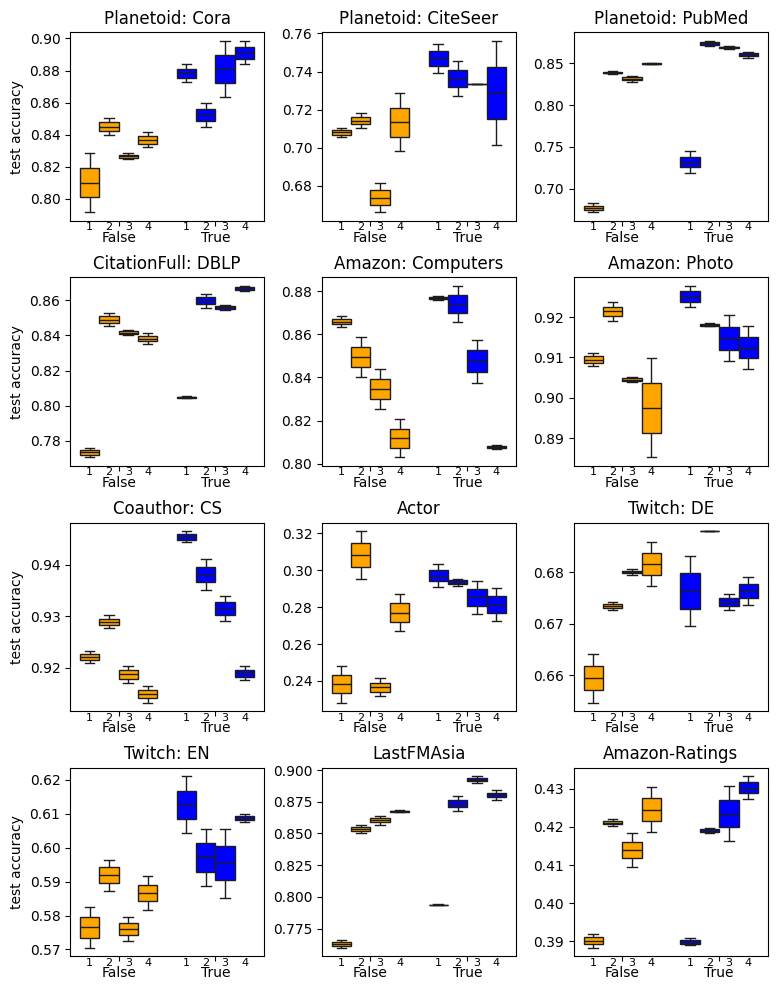

In [18]:
axs = plt.subplots(
    df["dataset"].nunique() // 3,
    3,
    figsize=(9, 12),
    sharex=False,
    sharey=False,
)[1].flatten()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (ax, dataset) in enumerate(zip(axs, df["dataset"].unique())):
    # Show the average GCN accuracy per layer using boxplots grouped by self-loops
    GCN_df = df[(df["dataset"] == dataset) & (df["model"] == "GCN")]
    box = sns.boxplot(
        x="self_loops",
        y="test_acc",
        data=GCN_df,
        ax=ax,
        hue="num_layers",
        showfliers=False,
    )

    # Color the boxes depending on if they have self-loops or not
    for j, patch in enumerate(ax.patches):
        if j % 2 == 0:
            patch.set_facecolor("orange")
        else:
            patch.set_facecolor("blue")

    # Add a second x-axis label
    x_ls, x_rs = get_box_plot_coords(n_classes=2, n_hue=max_num_layers)
    for y, x_l, x_r in zip([1, 2, 3, 4, 1, 2, 3, 4], x_ls, x_rs):
        box.annotate(
            y,
            xy=((x_l + x_r) / 2, -0.06),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
        )

    # Set the title, legend and axis labels
    ax.set_title(dataset)
    if i % 3 == 0:
        ax.set_ylabel(r"test accuracy")
    else:
        ax.set_ylabel("")
    if i == 13:
        ax.set_xlabel("number of layers + self-loops")
    else:
        ax.set_xlabel("")
    ax.legend().remove()

plt.savefig(get_results_path() / "real.pdf", bbox_inches="tight")
